In [1]:
import os
import torch
import math
import json
import random

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from typing import List, Dict, Tuple

In [2]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
device

2
True
0
NVIDIA GeForce RTX 3060


device(type='cuda')

# Explore Sample of Data

In [3]:
DATA_DIR = "/home/jaero/interviews/aws/vector_search/data/"
GEO_DATA_DIR = os.path.join(DATA_DIR, "geological_similarity")
classes = sorted([c for c in os.listdir(GEO_DATA_DIR) if c != ".DS_Store"])
classes

['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [4]:
def read_image_as_np_array(fpath: str) -> np.ndarray:
    """Utility function to read in image file as numpy array

    Args:
        fpath (str): file path to image

    Returns:
        np.ndarray: image returned as numpy array
    """
    with Image.open(fpath) as im:
        arr = np.asarray(im.convert('RGB'))
    return arr


In [5]:
sample_file = os.path.join(GEO_DATA_DIR, "gneiss/0A3V2.jpg")
arr = read_image_as_np_array(sample_file)
print(arr.shape)
Image.open(sample_file)

(28, 28, 3)


Notes: 
- Dimensions of image are very small
- low resolution may make it difficult to retrieve features from to distinguish from other images


/home/jaero/interviews/aws/vector_search/data/geological_similarity/andesite/G90MZ.jpg
	andesite - Before Upsampling:  (28, 28, 3)
	andesite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/gneiss/OXACJ.jpg
	gneiss - Before Upsampling:  (28, 28, 3)
	gneiss - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/marble/ET3ZO.jpg
	marble - Before Upsampling:  (28, 28, 3)
	marble - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/quartzite/2P7FP.jpg
	quartzite - Before Upsampling:  (28, 28, 3)
	quartzite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_similarity/rhyolite/E0DYQ.jpg
	rhyolite - Before Upsampling:  (28, 28, 3)
	rhyolite - After Upsampling:  torch.Size([112, 112, 3])

/home/jaero/interviews/aws/vector_search/data/geological_simila

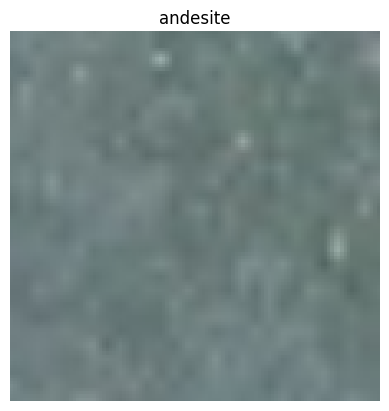

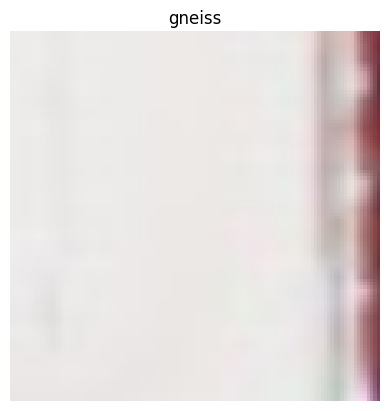

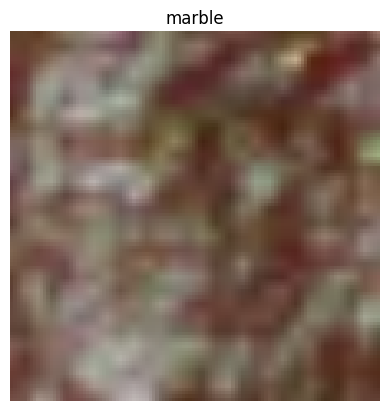

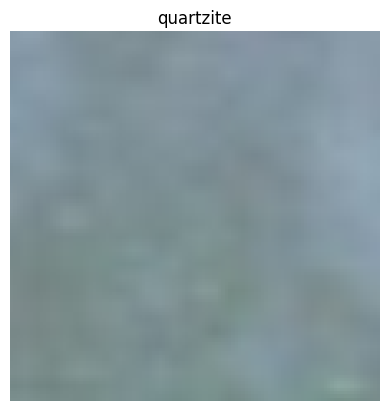

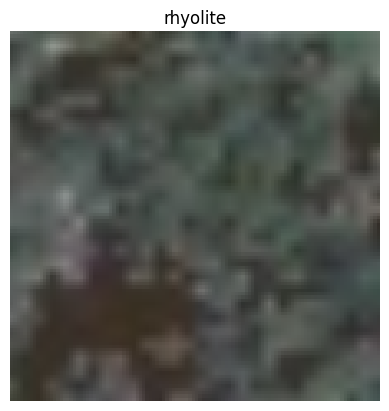

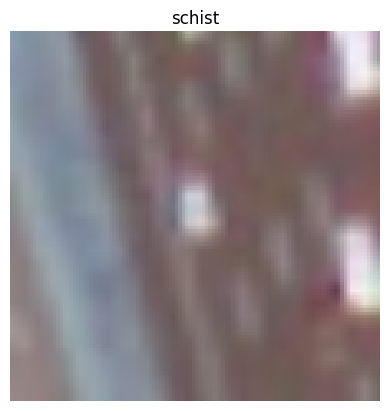

In [6]:
# showcase an example of each class
# use some basic upsampling for visualization purposes
import random

image_dict = {}
for c in classes:
    dirpath = os.path.join(GEO_DATA_DIR, c)
    sample_path = os.path.join(dirpath, os.listdir(dirpath)[random.randint(0, len(os.listdir(dirpath)))])
    arr = read_image_as_np_array(sample_path)
    print(f"\n{sample_path}")
    print(f"\t{c} - Before Upsampling: ", arr.shape)
    tensor = torch.tensor(arr).unsqueeze(0).permute(0,3,1,2)
    upsample_layer = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
    tensor = upsample_layer(tensor)
    tensor = tensor.squeeze(0).permute(1,2,0)
    print(f"\t{c} - After Upsampling: ", tensor.shape)
    img = Image.fromarray(tensor.detach().cpu().numpy())
    image_dict[c] = img


for c, img in image_dict.items():
    plt.figure()
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')


    

Notes
- upsampling to 56x56 helps to visualize images, but apart from color and some dense pixel areas the clarity and edge feautures are a bit obscure

# Metadata of Provided Dataset

In [7]:
metadata = []
for c in classes:
    sizes = set()
    count = 0
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR, c)):
        for file in files:
            fpath = os.path.join(root, file)
            arr = read_image_as_np_array(fpath)
            shape = arr.shape
            sizes.add(shape)
            count += 1 
    metadata.append({'class': c, 'sizes': [s for s in sizes], 'count': count})

df = pd.DataFrame(metadata)
df

,class,sizes,count
0,andesite,"[(28, 28, 3)]",5000
1,gneiss,"[(28, 28, 3)]",5000
2,marble,"[(28, 28, 3)]",4998
3,quartzite,"[(28, 28, 3)]",5000
4,rhyolite,"[(28, 28, 3)]",5000
5,schist,"[(28, 28, 3)]",5000


Notes: 
- consistent image sizes
- class distribution seem to be fairly balanced

## Attempt Super Resolution Using Pretrained Model ESRGAN
- Source Attribution: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution


In [8]:
"""
The following code in this block was taken from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution
in order to initialize a pretrained Super Resolution Model for input image augmentation

License: MIT License
"""

# Constants
rgb_weights = torch.FloatTensor([65.481, 128.553, 24.966]).to(device)
imagenet_mean = torch.FloatTensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
imagenet_std = torch.FloatTensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
imagenet_mean_cuda = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)
imagenet_std_cuda = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).unsqueeze(0).unsqueeze(2).unsqueeze(3)


class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """
    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """
    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """
    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs


class Generator(nn.Module):
    """
    The generator in the SRGAN, as defined in the paper. Architecture identical to the SRResNet.
    """
    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(Generator, self).__init__()

        # The generator is simply an SRResNet, as above
        self.net = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                            n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)

    def initialize_with_srresnet(self, srresnet_checkpoint):
        """
        Initialize with weights from a trained SRResNet.

        :param srresnet_checkpoint: checkpoint filepath
        """
        srresnet = torch.load(srresnet_checkpoint)['model']
        self.net.load_state_dict(srresnet.state_dict())

        print("\nLoaded weights from pre-trained SRResNet.\n")

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        sr_imgs = self.net(lr_imgs)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return sr_imgs


## Utility Classes/Functions

def convert_image(img, source, target):
    """
    Convert an image from a source format to a target format.

    :param img: image
    :param source: source format, one of 'pil' (PIL image), '[0, 1]' or '[-1, 1]' (pixel value ranges)
    :param target: target format, one of 'pil' (PIL image), '[0, 255]', '[0, 1]', '[-1, 1]' (pixel value ranges),
                   'imagenet-norm' (pixel values standardized by imagenet mean and std.),
                   'y-channel' (luminance channel Y in the YCbCr color format, used to calculate PSNR and SSIM)
    :return: converted image
    """
    assert source in {'pil', '[0, 1]', '[-1, 1]'}, "Cannot convert from source format %s!" % source
    assert target in {'pil', '[0, 255]', '[0, 1]', '[-1, 1]', 'imagenet-norm',
                      'y-channel'}, "Cannot convert to target format %s!" % target

    # Convert from source to [0, 1]
    if source == 'pil':
        img = FT.to_tensor(img)

    elif source == '[0, 1]':
        pass  # already in [0, 1]

    elif source == '[-1, 1]':
        img = (img + 1.) / 2.

    # Convert from [0, 1] to target
    if target == 'pil':
        img = FT.to_pil_image(img)

    elif target == '[0, 255]':
        img = 255. * img

    elif target == '[0, 1]':
        pass  # already in [0, 1]

    elif target == '[-1, 1]':
        img = 2. * img - 1.

    elif target == 'imagenet-norm':
        if img.ndimension() == 3:
            img = (img - imagenet_mean) / imagenet_std
        elif img.ndimension() == 4:
            img = (img - imagenet_mean_cuda) / imagenet_std_cuda

    elif target == 'y-channel':
        # Based on definitions at https://github.com/xinntao/BasicSR/wiki/Color-conversion-in-SR
        # torch.dot() does not work the same way as numpy.dot()
        # So, use torch.matmul() to find the dot product between the last dimension of an 4-D tensor and a 1-D tensor
        img = torch.matmul(255. * img.permute(0, 2, 3, 1)[:, 4:-4, 4:-4, :], rgb_weights) / 255. + 16.

    return img

In [9]:
# Load models
srresnet = SRResNet()
srgan_generator = Generator()

# Model checkpoints
srgan_checkpoint = "../saved_models/checkpoint_srgan.pth.tar"
srresnet_checkpoint = "../saved_models/checkpoint_srresnet.pth.tar"

# Load models
srresnet.load_state_dict(torch.load(srresnet_checkpoint,  weights_only=True))
srgan_generator.load_state_dict(torch.load(srgan_checkpoint,  weights_only=True))

srresnet.to(device)
srgan_generator.to(device)

srresnet.eval()
srgan_generator.eval()


def test_super_res(img_path):
    lr_img = Image.open(img_path).convert('RGB')
    bicubic_img  = lr_img.resize((112, 112), Image.BICUBIC)
    hr_img = bicubic_img

    # Super-resolution (SR) with SRResNet
    sr_img_srresnet = srresnet(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source='[-1, 1]', target='pil')

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).cpu().detach()
    sr_img_srgan = convert_image(sr_img_srgan, source='[-1, 1]', target='pil')

    return lr_img, bicubic_img, sr_img_srresnet, sr_img_srgan

/home/jaero/interviews/aws/vector_search/data/geological_similarity/andesite/NJISH.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/gneiss/A5MFB.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/marble/H83CM.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/quartzite/VSGQU.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/rhyolite/BGCF6.jpg
	Super Res Dimensions: (112, 112)
/home/jaero/interviews/aws/vector_search/data/geological_similarity/schist/QR3HI.jpg
	Super Res Dimensions: (112, 112)


/tmp/ipykernel_56854/1710353438.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


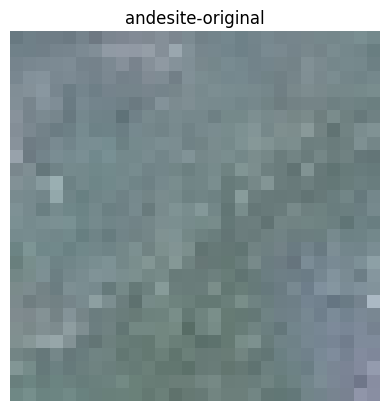

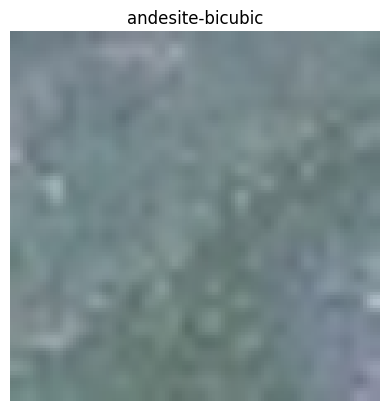

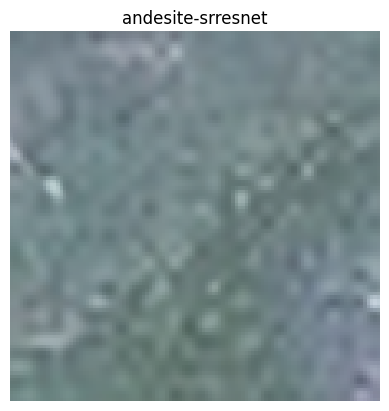

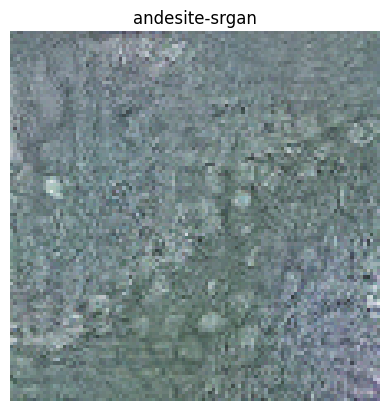

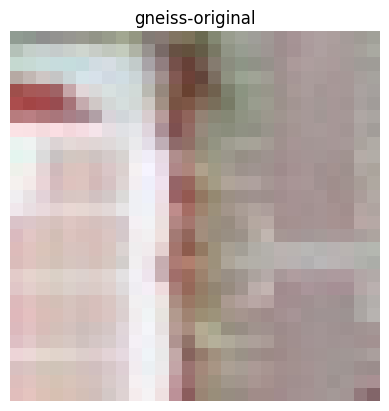

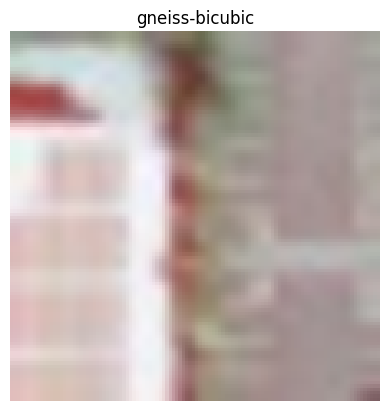

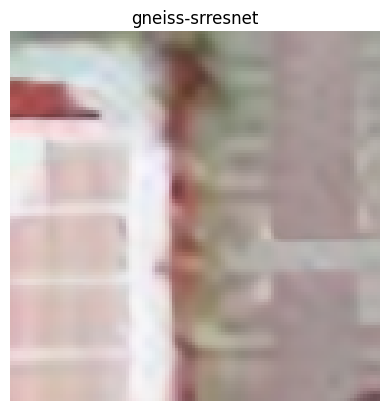

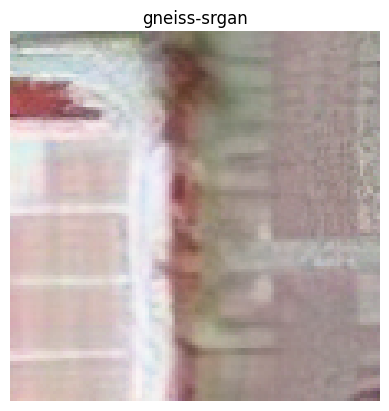

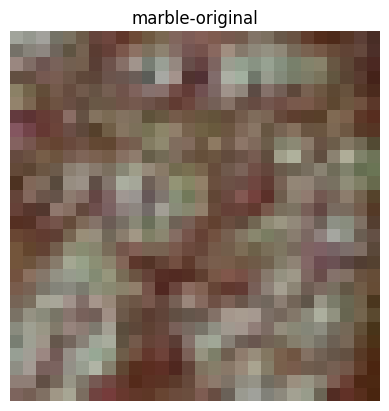

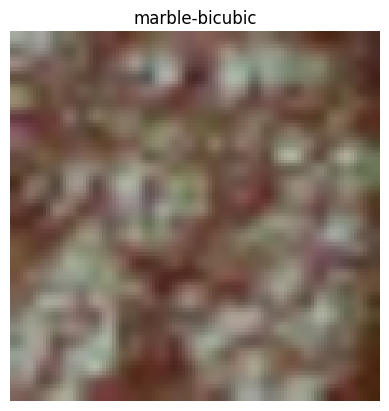

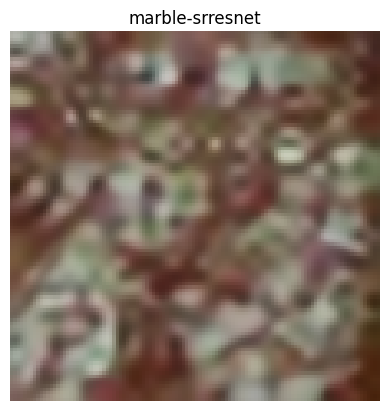

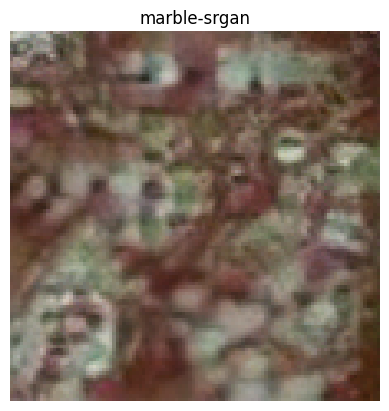

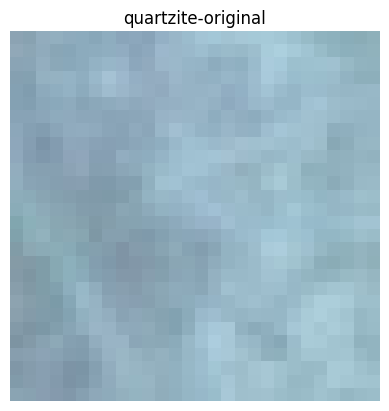

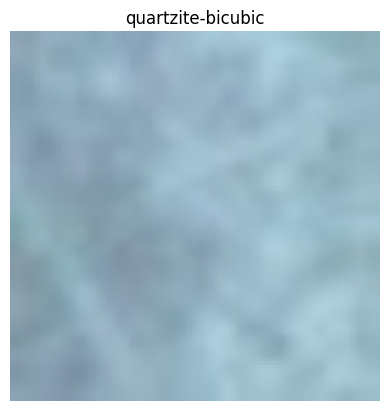

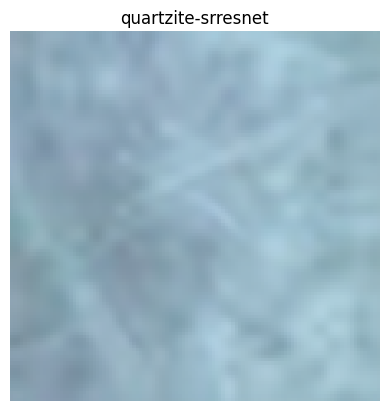

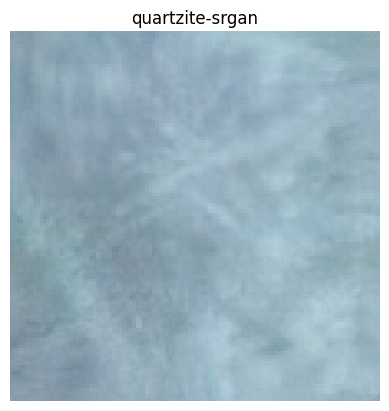

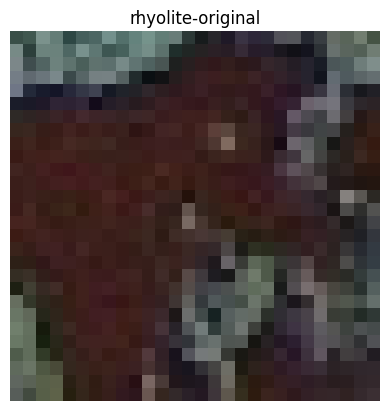

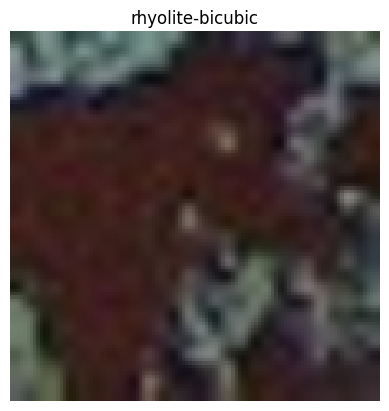

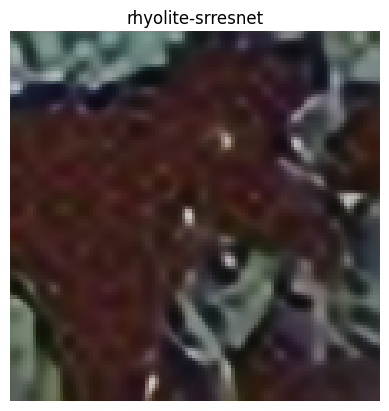

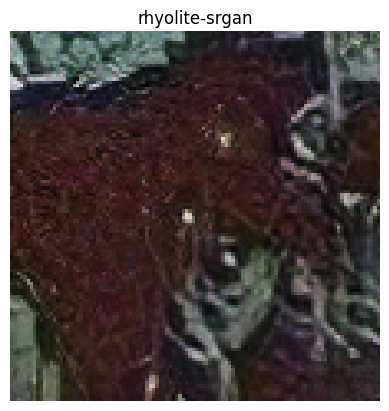

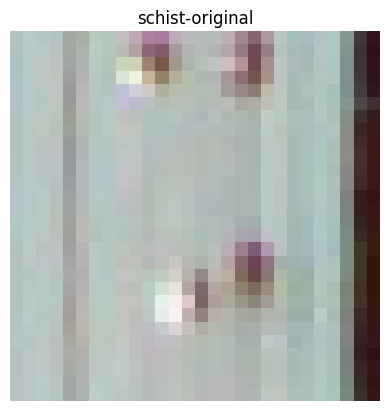

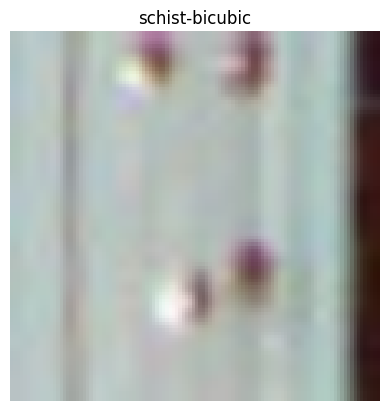

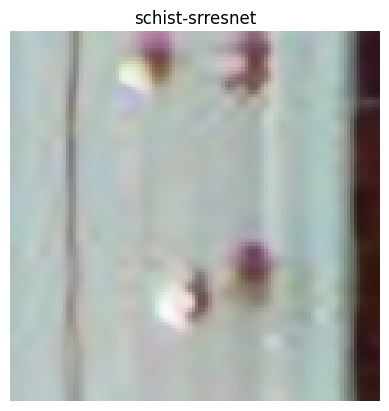

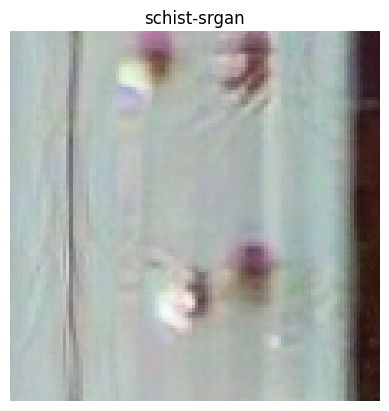

In [10]:
# showcase an example of each class
# use some basic upsampling for visualization purposes
image_dict = {}

for c in classes:
    # read in image from file
    dirpath = os.path.join(GEO_DATA_DIR, c)
    sample_path = os.path.join(dirpath, os.listdir(dirpath)[random.randint(0, len(os.listdir(dirpath)))])
    print(sample_path)
    lr_img, bicubic_img, sr_img_srresnet, sr_img_srgan = test_super_res(sample_path)
    print(f'\tSuper Res Dimensions: {sr_img_srgan.size}')
    plot_data = [(f'{c}-original', lr_img), 
                 (f'{c}-bicubic', bicubic_img), 
                 (f'{c}-srresnet', sr_img_srresnet), 
                 (f'{c}-srgan', sr_img_srgan)]
    for title, img in plot_data:
        plt.figure()
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')


- Resolution quality is a bit better, though GAN seems to have smoothed the edges and provide more distinctive features, so may prefer to use SRGAN instead of SRResnet
- [Future Work] May be worth training a custom low res -> high res model for these specific geo images
- (112, 112) dim should be a large enough dimension to work with for encoding image into image embeddings for vector similarity search

# Is it Possible to Train a Simple, Performant Image Classifcation on this Data? 
- Should help determine how useful our reduced dimensionality vector similarity search engine will be
- Especially when it comes to distinction of features across classes and similarity of features within each class
- Q: Will super resolution improve the models performance?

## Train, Val, Test Split
- Can be used for classification as well as image embedding model

In [11]:
# Train, Val, Test Split
random.seed(10)

data = []
for c in classes:
    for root, dirs, files in os.walk(os.path.join(GEO_DATA_DIR, c)):
        for file in files:
            fpath = os.path.join(root, file)
            img = Image.open(fpath).convert('RGB')
            tensor = FT.to_tensor(img)
            mean, std = tensor.mean(), tensor.std()
            data.append({ 'class': c, 'file': file, 'file_path': fpath, 'mean': mean.numpy(), 'std': std.numpy() })

df = pd.DataFrame(data)
df['train'] = 0
df['val'] = 0
df['test'] = 0

# shuffle and split across classes for balancing purposes
# 60:20:20 train:val:test
train, val ,test = [], [], []
for c in classes:
    file_paths = df[df['class'].eq(c)]['file_path'].to_list()
    random.shuffle(file_paths)
    N = len(file_paths)
    train_idx = round(N*0.6)
    val_idx = train_idx + round(N*0.2)
    test_idx = val_idx + round(N*0.2)
    if test_idx > N: test_idx = N
    # split
    train.extend(file_paths[:train_idx])
    val.extend(file_paths[train_idx:val_idx])
    test.extend(file_paths[val_idx:test_idx])

train = {f: None for f in train}
val = {f: None for f in val}
test = {f: None for f in test}

# Update df
for i, row in df.iterrows():
    fpath = row['file_path']
    if fpath in train: df.at[i, 'train'] = 1
    elif fpath in val: df.at[i, 'val'] = 1
    elif fpath in test: df.at[i, 'test'] = 1


train_count = df['train'].value_counts()[1]
val_count = df['val'].value_counts()[1]
test_count = df['test'].value_counts()[1]

print(f"Total Samples: {len(df.index)}")
print(train_count, val_count, test_count)
assert len(df.index) == train_count + val_count + test_count

print(f"\nTRAIN\n{df[df['train'].eq(1)]['class'].value_counts()}\n")
print(f"VALIDATION\n{df[df['val'].eq(1)]['class'].value_counts()}\n")
print(f"TEST\n{df[df['test'].eq(1)]['class'].value_counts()}\n")

# save df split
df.to_csv(os.path.join(DATA_DIR, 'train_val_test_splits', 'data_split-1.csv'), index=False)
df


Total Samples: 29998
17999 6000 5999

TRAIN
class
andesite     3000
gneiss       3000
quartzite    3000
rhyolite     3000
schist       3000
marble       2999
Name: count, dtype: int64

VALIDATION
class
andesite     1000
gneiss       1000
marble       1000
quartzite    1000
rhyolite     1000
schist       1000
Name: count, dtype: int64

TEST
class
andesite     1000
gneiss       1000
quartzite    1000
rhyolite     1000
schist       1000
marble        999
Name: count, dtype: int64



,class,file,file_path,mean,std,train,val,test
0,andesite,RAD1H.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.47556192,0.047819547,1,0,0
1,andesite,L6POO.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.4816977,0.09681573,1,0,0
2,andesite,1W93C.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.33338335,0.08926363,0,1,0
3,andesite,J7FX0.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.45159563,0.04516597,0,1,0
4,andesite,1SPCS.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.51225823,0.043973472,1,0,0
...,...,...,...,...,...,...,...,...
29993,schist,CT713.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.58993936,0.054694485,0,1,0
29994,schist,ZETTG.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.52657896,0.059532225,1,0,0
29995,schist,1IN00.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.7629652,0.08741079,1,0,0
29996,schist,QKFYT.jpg,/home/jaero/interviews/aws/vector_search/data/...,0.5907213,0.07755508,1,0,0


# Image Similarity Search - Solutioning

- **Step 1:** SuperResolutionModel(OriginalImage (24x24)) --> UsableImage (112x112)
- **Step 2:** ImageEmbeddingModel(UsableImage) -> VectorEmbedding () [requires model training for ImageEmbeddingModel]
- **Step 3:** Create Vector Index for Approximate Nearest Neighbor Search (e.g. FAISS, ANNOY) 
- **Step 3a:** (Optional) Utilize a Vector Database (e.g. PineconeDB) to store image embeddings
- **Step 4:** Build and Deploy Containerized Web Application for users to be able to upload image of their choice and return Top K similar images
- **Step 4a:** Top K+N similar vector candidates returned using direct similarity metric calculation (e.g. cosine similarity) where N is tunable depending on computational vs accuracy performance balance
- **Step 4b:** (Optional) Similar vector candidates are then re-ranked according to similarity based on original resolution of images instead in order to account for potential information loss when encoding images into smaller vector representations
- **Step 4c:** Top K similar images are presented to the user based on the input image they uploaded

# Image Embedding Model